# Basic use of the oimBinaryOrbit component

This is a basic example showing the main features of the oimBinary components:
    
- Creation of the component
- Getting binary separation (x,y) using the getSeparation method 
- Plotting the projected orbit
- Changing components type from point source to UD
- Computing and plotting time-dependent visibilities ( with getComplexCoherentFlux)
- Case of a chromatic binary with different temperature
- Simulating Radial velocity

More advanced features such as model-Fitting of visibilities, radial-velocities
and separations are presented in the exampleOimBinaryRvAndSep example

We start by some basic imports and setting of the path.

In [3]:
from pathlib import Path
import astropy.units as u
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
from astropy.io import ascii
from astropy.time import Time
import oimodeler as oim
import os

plt.rcParams["xtick.minor.visible"] = True
plt.rcParams["ytick.minor.visible"] = True


path = Path(os.getcwd()).parents[3] # oimodeler package root path


The **oimBinaryOrbit** component can be defined with values of the 7 orbital parameters of the projected orbit:

- T0 : Time Periastron passage (MJD)
- T : Period (days)
- a : semi-major axis (mas)
- e : excentricity
- i : inclination angle (deg)
- O : Longitude of ascending node (deg)
- o : Argument of periastron (deg)


In [5]:
T0 = 0
T  = 1
orb = oim.oimBinaryOrbit(T0 = T0,     # Time Periastron passage (MJD by default or decimal year)
                         T  = T,      # Period (in days by default or any compatible astropy unit if specified)
                         a  = 10,  # semi-major axis (mas)
                         e  = 0.4, # Eccentricity
                         i  = 45,   # inclination angle (deg)
                         O  = 40,   # Longitude of ascending node (deg)
                         o  =-20    # Argument of periastron
                         )


## Plotting the orbit with the **getSeparation** method

The binary separation can be accessed using the **getSeparation** method that takes time (in MJD) as an argument.

We first define two time vectors, one for the plot of the orbit with 100 points and one for plot annotation with onyl 7, and then passe them to the  **getSeparation** method. 

By default the method return the (x,y) coordinates of the orbits in rad. The use of the mas keyword allows to retrieve them in a more useful unit.

In [7]:
nt2 = 7
t = np.linspace(T0, T0 + T, 100)
t2 = np.linspace(T0, T0 + T, nt2)
x, y = orb.getSeparation(t, mas=True)
x2, y2 = orb.getSeparation(t2, mas=True)


We can now plot the orbit 

(10.0, -15.0)

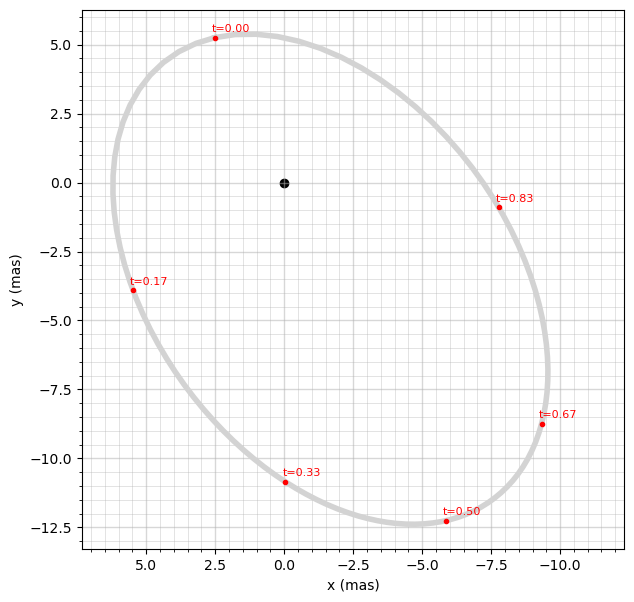

In [9]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.grid(which="major", lw=1, alpha=0.5, zorder=-10)
ax.grid(which="minor", lw=0.5, alpha=0.5, zorder=-10)

ax.plot(x, y, color="lightgrey", alpha=1, lw=4)
ax.scatter(x2[:-1], y2[:-1], color="r", marker=".", zorder=10)

for i in range(nt2 - 1):
    ax.annotate(
        f"t={t2[i]:.2f}",
        (x2[i] + 0.1, y2[i] + 0.2),
        color="r",
        zorder=10,
        fontsize=8,
    )
ax.axis("equal")

ax.scatter(0, 0, marker="o", color="k")
ax.set_xlabel("x (mas)")
ax.set_ylabel("y (mas)")
ax.set_xlim(10, -15)

## Computing interferometric measurements 

Without external data we can compute the visibility as for any other **oimComponent** using the **getComplexCoherentFlux** method of the **oimModel** class.

We first build a oimModel containing our binary orbit component.

In [11]:
morb = oim.oimModel(orb)

By default, the two stars (primary and secondary) of the binary system are defined as point like source using the **oimPt**. 

The primary and secondary components can be accessed by the **primary**, and **secondary** member variable.

They can be replaced by other **oimComponent** such as a uniform disk (oimUD) to simulate resolved objets.


In [13]:
orb.primary = oim.oimUD(d=3)

The component can also be accessed and modified. 

Here, we set the flux of the secondary to 0.3

In [15]:
orb.secondary.params["f"].value = 0.3

Let's now plot visibilitvies for 0 to 100m baseline at 2.1$\mu$m and at the 7 dates of observations defined by t2 as shown in the orbit plot.

We first create a **oimModel** containing our binary component.

In [17]:
morb = oim.oimModel(orb)

We then create the spatial frequence to to givezn to the **getComplexCoherentFlux** method

In [19]:
N = 200
wl = 2.1e-6
B = np.linspace(0.0, 100, num=N)
spf = B / wl


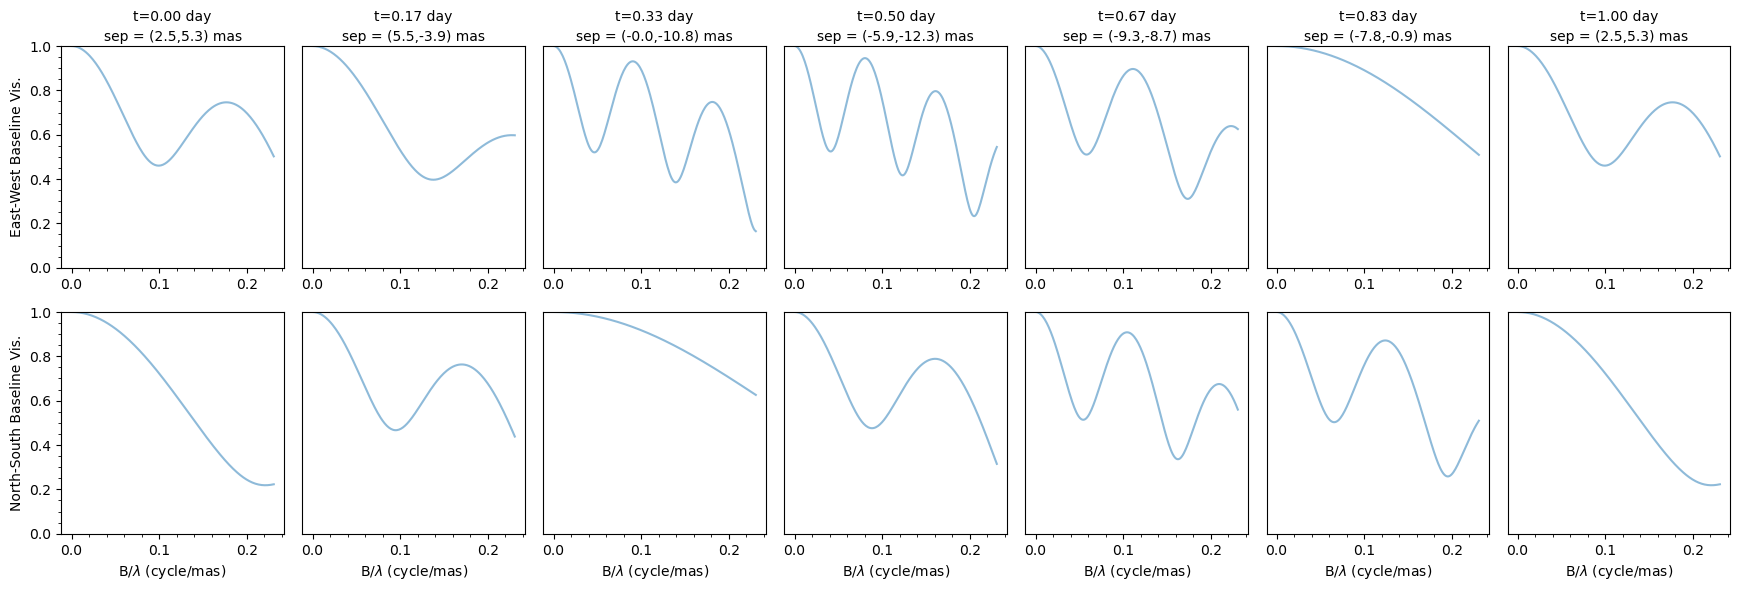

In [20]:
fig, ax = plt.subplots(2, nt2, figsize=(nt2 * 2.5, 6), sharex="row", sharey="row")
mascycle = 1.0 / u.rad.to(u.mas)

for iT in range(nt2):
    for iPA in range(2):
        v = np.abs(morb.getComplexCoherentFlux(spf * (iPA == 1), spf * (iPA == 0), t=np.ones(N) * t2[iT]))
        v = v / np.max(v)
        ax[iPA, iT].plot(spf * mascycle, v, alpha=0.5)
        ax[iPA, iT].set_ylim(0, 1)

    ax[0, iT].text(0.5, 1.01, f"sep = ({x2[iT]:.1f},{y2[iT]:.1f}) mas", transform=ax[0, iT].transAxes, va="bottom", ha="center")
    ax[0, iT].text(0.5, 1.10, f"t={t2[iT]:.2f} day", transform=ax[0, iT].transAxes, va="bottom", ha="center")
    ax[1, iT].set_xlabel("B/$\\lambda$ (cycle/mas)")
    if iT != 0:
        ax[0, iT].axes.get_yaxis().set_visible(False)
        ax[1, iT].axes.get_yaxis().set_visible(False)

ax[0, 0].set_ylabel("East-West Baseline Vis.")
ax[1, 0].set_ylabel("North-South Baseline Vis.")

plt.tight_layout()

We can also check the position computed from the visibility compared to the orbit using the **showModel** method with **fromFT=True** option and overplotting the orbit as determined previously by the **getSeparation** method

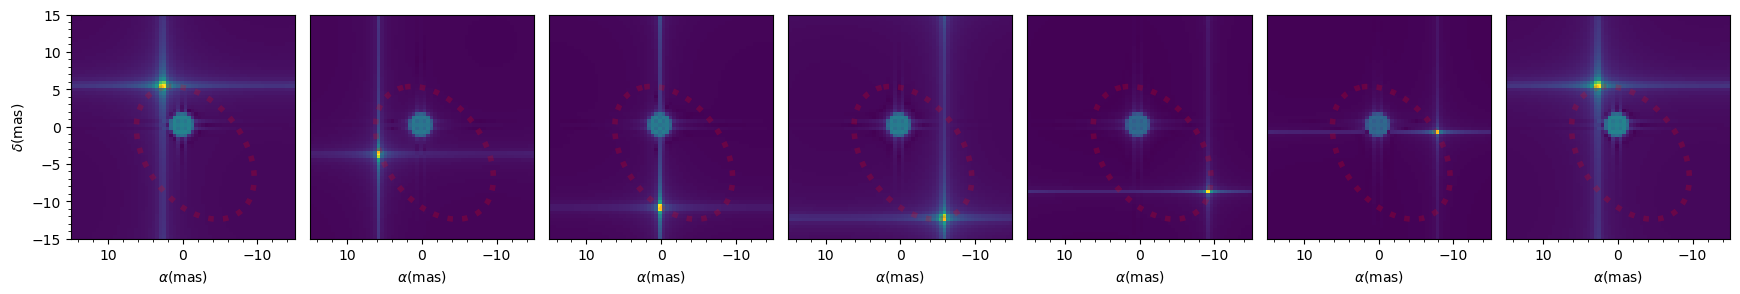

In [22]:
fig, ax = plt.subplots(1, nt2, figsize=(nt2 * 2.5, 3), sharex="row")

dim = 64
fov = 30
pix = fov / dim
for iT in range(nt2):
    morb.showModel(dim, pix, t=t2[iT], fromFT=True, axe=ax[iT], normPow=0.5, colorbar=False)
    ax[iT].plot(x, y, color="r", alpha=0.2, lw=4, ls=":")
    if iT != 0:
        ax[iT].axes.get_yaxis().set_visible(False)
plt.tight_layout()

Here we compute the visibliity for a set of 500 North-South and 500 East-West baselines with length ranging from 0 to 100m and at 500 epoch raning on the full binary period.

In [24]:
nt = 500  # number of epochs in one period
t = np.linspace(T0, T0 + T, nt)

nB = 500  # number of baselines
wl = 2.1e-6  # fixed wavelength
B = np.linspace(0.0, 100, num=nB)
spf = B / wl

Bs = np.tile(B, (nt, 1))
ts = np.transpose(np.tile(t, (nB, 1)))
spf = Bs / wl
spf0 = spf * 0

vis1 = np.abs(morb.getComplexCoherentFlux(spf.flatten(), spf.flatten() * 0, t=ts.flatten())).reshape(len(t), len(B))
vis1 /= np.outer(np.max(vis1, axis=1), np.ones(nB))
vis2 = np.abs(morb.getComplexCoherentFlux(spf.flatten() * 0, spf.flatten(), t=ts.flatten())).reshape(len(t), len(B))
vis2 /= np.outer(np.max(vis2, axis=1), np.ones(nB))


We then plot the visiblity maps for these two set of baselines

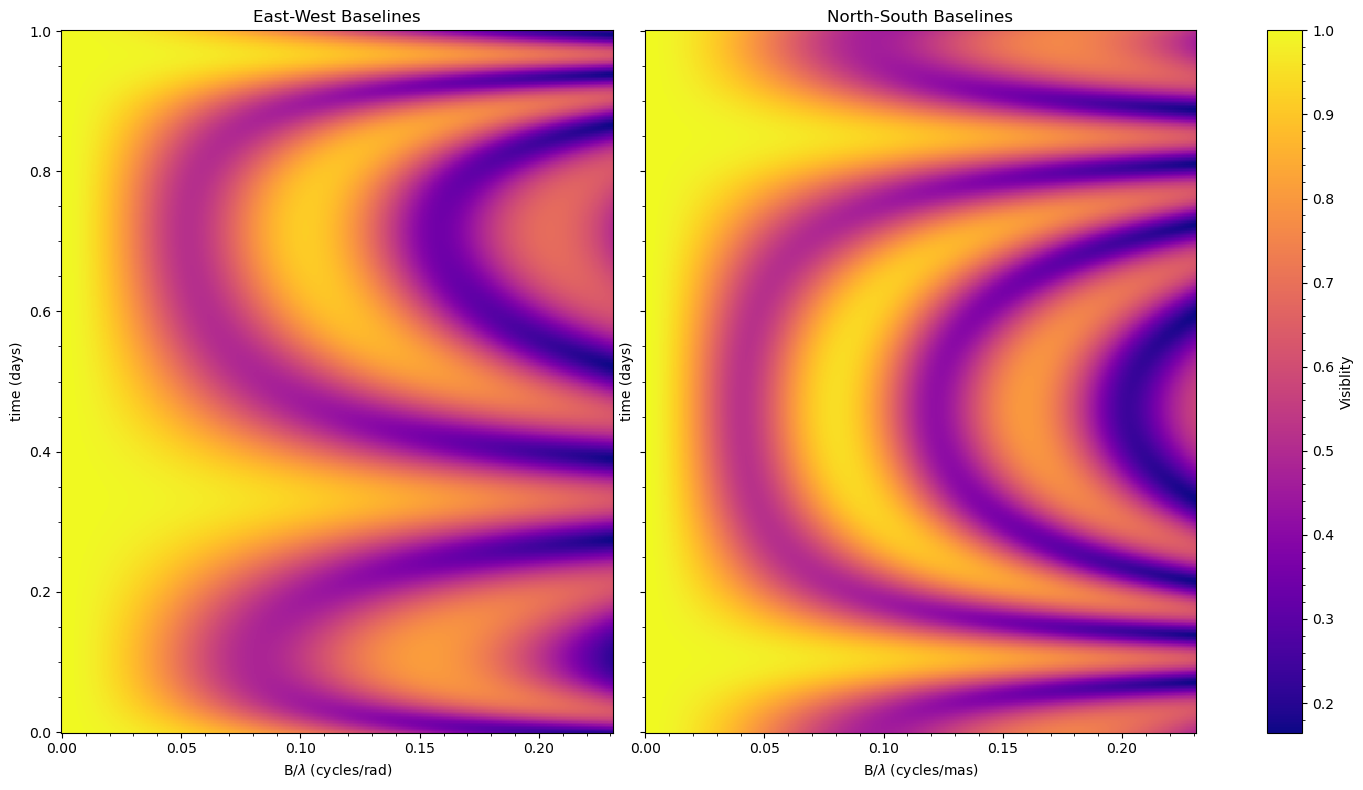

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8), sharex=True, sharey=True)

ax[0].pcolormesh(spf/u.rad.to(u.mas), ts, vis1, cmap="plasma")
sc = ax[1].pcolormesh(spf/u.rad.to(u.mas), ts, vis2, cmap="plasma")

ax[0].set_xlabel("B/$\\lambda$ (cycles/rad)")
ax[0].set_ylabel("time (days)")
ax[0].set_title("East-West Baselines")
ax[1].set_xlabel("B/$\\lambda$ (cycles/mas)")
ax[1].set_ylabel("time (days)")
ax[1].set_title("North-South Baselines")
plt.tight_layout()
cb = fig.colorbar(sc, ax=ax, label="Visiblity")

##Chromatic case with components with different temperatures

Let's simulate a binary system with:
- a 3000K main sequence star modelled as a uniform UD
- a 30000K unresolved white dwarf, therefore modelled as a point source.

To take into account the realistic variation of the flux of the two component as a function of the wavelength we use the  **starWl** interpolator  to set a blackbody flux to each component.

First we create the two components:


In [28]:
dist = 100

#We use the "starWl"" interpolator to set a blackbody flux to each component.
orb.primary = oim.oimUD(d=1, f=oim.oimInterp("starWl", temp=3000, dist=dist, radius=0.5))
orb.secondary = oim.oimPt(f=oim.oimInterp("starWl", temp=30000, dist=dist, radius=0.1))


Now we create a 2D array of 2000 spatial frequencies ranging from 0 to 1.5x the resolution of the primary component by 400 wavelength ranging from 1 to 4 $\mu$m.

In [30]:
nwl = 400
nspf = 2000

# first zero of the primary used to define the spatial-frequency range
spf_res = 1.22 / (orb.primary.params["d"].value * u.mas.to(u.rad)) 

spf = np.linspace(0, spf_res * 1.5, nspf)
wl = np.linspace(1e-6, 4e-6, num=nwl)
wl = np.logspace(-6, -5.4, num=nwl)
spf_2D = np.tile(spf, (nwl, 1)).flatten()
wl_2D = np.transpose(np.tile(wl, (nspf, 1))).flatten()


We compute the complex coherent flux and then visiblisity for this set of spatial and spectral coordinates.

In [32]:
vis = np.abs(morb.getComplexCoherentFlux(spf_2D, spf_2D * 0, wl_2D, t=spf_2D * 0 + 0.1)).reshape(nwl, nspf)
vis /= np.outer(np.max(vis, axis=1), np.ones(nspf))

Finally we plot the resulting visiblity as the function of the spatial frequency with a colorscale for the wavelength to show the modification of the amplitude of the modulation (linked to the flux ratio between the components) as a function of the wavelength.

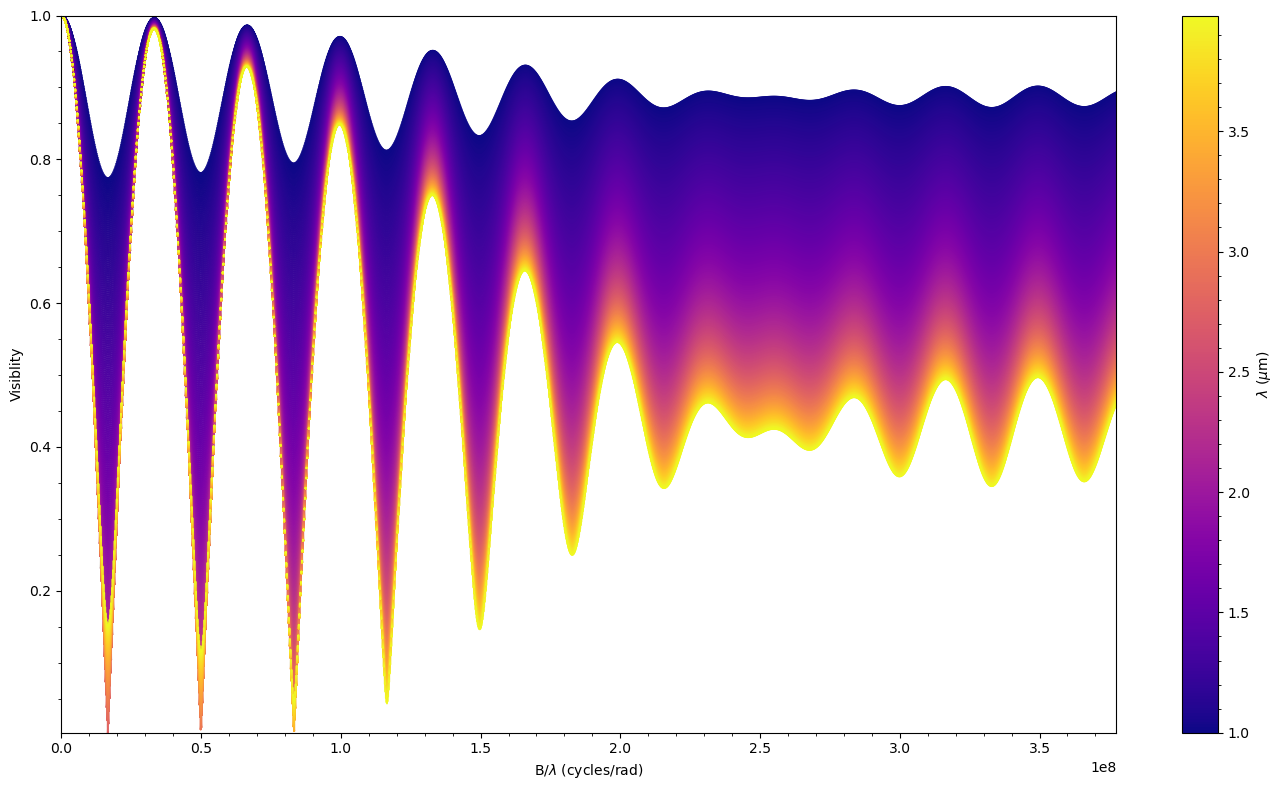

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(14, 8))
sc = ax.scatter(spf_2D, vis, c=wl_2D * 1e6, s=0.2, cmap="plasma")

ax.set_xlabel("B/$\\lambda$ (cycles/rad)")
ax.set_ylabel("Visiblity")
ax.margins(0, 0)
plt.tight_layout()
cb = fig.colorbar(sc, ax=ax, label="$\\lambda$ ($\\mu$m)")

We can highlight the flux variation by plotting the fluxes of both components as a function of the wavelength

Text(0, 0.5, 'Flux (Jy)')

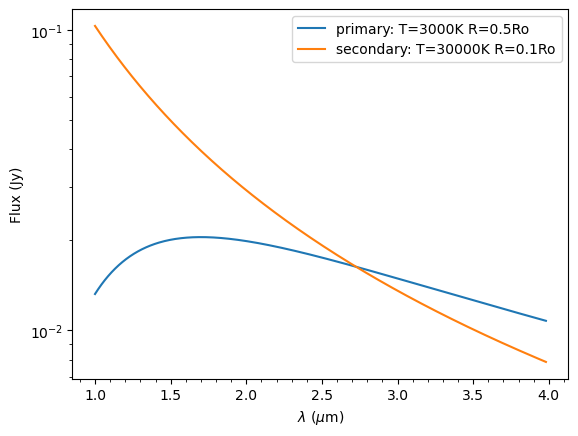

In [36]:
fp = orb.primary.params["f"](wl)
fs = orb.secondary.params["f"](wl)

fig, ax = plt.subplots()

ax.plot( wl * 1e6, fp,
          label=f"primary: T={orb.primary.params['f'].temp.value}K " \
                f"R={orb.primary.params['f'].radius.value}Ro")
ax.plot(wl * 1e6, fs, 
        label=f"secondary: T={orb.secondary.params['f'].temp.value}K " \
              f"R={orb.secondary.params['f'].radius.value}Ro")
ax.legend()
ax.set_yscale("log")
ax.set_xlabel("$\\lambda$ ($\\mu$m)")
ax.set_ylabel("Flux (Jy)")

## Computing radial velocities from the orbit with the **getRadialVelocities** method

The **oimBinaryOrbit** component also allow to compute radial velocities at different time using the methods:

- **getPrimaryRadialVelocity**: for SB1 binaries
- **getRadialVelocities**: for SB2 binaries

In that case the users need to set the additionnal parameters of the  **oimBinaryOrbit** :
- **V0** : Systemic velocity  (km/s by default)
- **Ka** : Radial Velocity semi-amplitude of the primary (km/s by default)      
- **Kb** : Radial Velocity semi-amplitude of the secondary (km/s by default)

**Kb** needs to be defined only for SB2 binaries.


 

In [38]:
orb.params["Ka"].value = 5
orb.params["Kb"].value = 50
orb.params["V0"].value = -5

Here, we define a time vector for two full period of the binary and compute the radial velocities curve for both components

In [40]:
t = np.linspace(T0,T0+2*T,nt*2)
rv_a, rv_b = orb.getRadialVelocities(t)

We finally plot the resulting RV curve

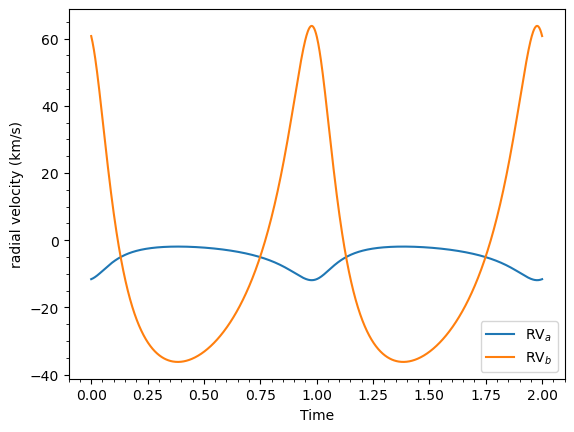

In [42]:
fig, ax = plt.subplots()
ax.plot(t, rv_a, label="RV$_a$")
ax.plot(t, rv_b, label="RV$_b$")
ax.set_xlabel("Time")
ax.set_ylabel("radial velocity (km/s)")
ax.legend()